In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import mne
from moabb.datasets import BNCI2014_001
from moabb.paradigms import MotorImagery
from mne_connectivity import spectral_connectivity_epochs, phase_slope_index
from mne_connectivity.viz import plot_sensors_connectivity
import matplotlib.pyplot as plt
from nilearn import plotting
from matplotlib import colormaps
import warnings
import os
import pyvista as pv


<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
/home/hice1/mchen439/scratch/miniconda3/envs/MATH8803/lib/python3.11/site-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.


In [2]:
def symmetrize(a):
	return a + a.T - np.diag(np.diag(a))

In [3]:
# From https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8865144/ Table 2 Cortex Means
ch_names = [
    "Fz", "FC3", "FC1", "FCz", "FC2", "FC4", "C5", "C3", "C1", "Cz", "C2",
        "C4", "C6", "CP3", "CP1", "CPz", "CP2", "CP4", "P1", "Pz", "P2", "POz",
        "EOG1", "EOG2", "EOG3"
]

EEG_Locations = {
	"Fz": [0.88, 34.43, 62.21],
	"FC3": [-46.09, 7.35, 56.46],
	"FC1": [-24.69, 5.73, 71.11],
	"FCz": [0.41, 6.77, 75.19],
	"FC2": [24.09, 5.4, 72.18],
	"FC4": [47.52, 6.49, 58.34],
	"C5": [-66.15, -20.58, 33.83],
	"C3": [-50.88, -21.18, 59.95],
	"C1": [-25.56, -23.82, 75.26],
	"Cz": [-0.47, -24.64, 80.16],
	"C2": [23.84, -24.31, 78.00],
	"C4": [50.78, -23.18, 63.58],
	"C6": [66.48, -21.77, 36.16],
	"CP3": [-49.15, -47.78, 58.42],
	"CP1": [-25.64, -48.14, 71.46],
	"CPz": [-0.73, -50.47, 75.85],
	"CP2": [24.46, -49.71, 75.38],
	"CP4": [46.66, -48.71, 62.98],
	"P1":  [-25.9, -68.45, 61.21],
	"Pz": [-1.94, -69.12, 66.04],
	"P2": [20.8, -69.28, 64.82],
	"POz": [-2.76, -90.20, 42.12]
}

EEG_Locations_list = []
for k, v in EEG_Locations.items():
	EEG_Locations_list.append(v)

EEG_Locations_list = np.array(EEG_Locations_list, dtype=float)
print(EEG_Locations_list.shape)


(22, 3)


In [4]:
paradigm = MotorImagery(n_classes=4)
mne.set_config("MNE_DATA", "/home/hice1/mchen439/scratch/mne_data")
mne.set_config("MNE_DATASETS_BNCI_PATH", "/home/hice1/mchen439/scratch/mne_data")
print(mne.get_config())

datasetMotorImagery = BNCI2014_001()
subjects = [1]
with warnings.catch_warnings(action="ignore"):
	X, y, metadata = paradigm.get_data(dataset=datasetMotorImagery, subjects=subjects)
print(metadata.columns)
print(np.unique(y))

y_encoded = np.zeros(y.shape)
for idx in range(y.shape[0]):
	if y[idx] == "tongue":
		y_encoded[idx] = 0
	elif y[idx] == "right_hand":
		y_encoded[idx] = 1
	elif y[idx] == "left_hand":
		y_encoded[idx] = 2
	else:
		y_encoded[idx] = 3

print(X.shape, y.shape, type(X), type(y), print(metadata.shape), print(type(metadata)))

Choosing from all possible events


{'MNE_DATA': '/home/hice1/mchen439/scratch/mne_data', 'MNE_DATASETS_ALEXEEG_PATH': '/home/hice1/mchen439/mne_data', 'MNE_DATASETS_BNCI_PATH': '/home/hice1/mchen439/scratch/mne_data', 'MNE_DATASETS_EEGBCI_PATH': '/home/hice1/mchen439/mne_data', 'MNE_DATASETS_FAKEDATASET-IMAGERY-10-2--60-60--120-120--FAKE1-FAKE2-FAKE3--C3-CZ-C4_PATH': '/tmp/tmpwour6ucf', 'MNE_DATASETS_FAKEVIRTUALREALITYDATASET-P300-21-1--60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60--120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120--TARGET-NONTARGET--C3-CZ-C4_PATH': '/tmp/tmpvhx98uwa', 'MNE_DATASETS_GIGADB_PATH': '/home/hice1/mchen439/mne_data', 'MNE_DATASETS_LEE2019-MI_PATH': '/home/hice1/mchen439/mne

/scratch/599053/ipykernel_99329/3128260298.py:3: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_BNCI_PATH"
  mne.set_config("MNE_DATASETS_BNCI_PATH", "/home/hice1/mchen439/scratch/mne_data")


Index(['subject', 'session', 'run'], dtype='object')
['feet' 'left_hand' 'right_hand' 'tongue']
(576, 3)
<class 'pandas.core.frame.DataFrame'>
(576, 22, 1001) (576,) <class 'numpy.ndarray'> <class 'numpy.ndarray'> None None


In [5]:
subjects = [1]
with warnings.catch_warnings(action="ignore"):
	epochs, y, metadata = paradigm.get_data(dataset=datasetMotorImagery, subjects=subjects, return_epochs=True)

# Plot the sensor locations
sens_loc = [epochs.info["chs"][k]["loc"][:3] for k in range(len(epochs.info.get_channel_types()))]
sens_loc = np.array(sens_loc)
print(sens_loc.shape)


Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
576 matching events found
No baseline correction applied
(22, 3)


In [18]:
print(epochs.info['chs'][0]['coord_frame'])
print(epochs.info['chs'][1]['coord_frame'])
print(epochs.info['chs'][2]['coord_frame'])
print(epochs.info['chs'][19]['coord_frame'])

4 (FIFFV_COORD_HEAD)
4 (FIFFV_COORD_HEAD)
4 (FIFFV_COORD_HEAD)
4 (FIFFV_COORD_HEAD)


In [19]:
epochs.info["ch_names"]

['Fz',
 'FC3',
 'FC1',
 'FCz',
 'FC2',
 'FC4',
 'C5',
 'C3',
 'C1',
 'Cz',
 'C2',
 'C4',
 'C6',
 'CP3',
 'CP1',
 'CPz',
 'CP2',
 'CP4',
 'P1',
 'Pz',
 'P2',
 'POz']

In [20]:
print(sens_loc)

[[-0.00122927  0.09327445  0.10263929]
 [-0.06185234  0.05713329  0.09376583]
 [-0.03571586  0.06171406  0.11798302]
 [-0.00127143  0.06345979  0.12657198]
 [ 0.03313098  0.06182849  0.1167817 ]
 [ 0.06062548  0.05770742  0.09379462]
 [-0.0820853   0.01929363  0.06948967]
 [-0.06714872  0.02335823  0.10451068]
 [-0.03793782  0.02633745  0.12977061]
 [-0.00137413  0.02761709  0.14019949]
 [ 0.03589272  0.02635814  0.12841234]
 [ 0.06532888  0.0235731   0.10369243]
 [ 0.08165317  0.01969566  0.06948181]
 [-0.06547223 -0.0118966   0.10777792]
 [-0.03742513 -0.01082424  0.13344371]
 [-0.0015249  -0.01051838  0.14154914]
 [ 0.03647196 -0.01090379  0.13281227]
 [ 0.06469626 -0.01199118  0.10771287]
 [-0.03065362 -0.04492739  0.11947205]
 [-0.00170945 -0.04521299  0.12667292]
 [ 0.02988639 -0.04503254  0.12074782]
 [-0.00189982 -0.0680541   0.09591   ]]


In [9]:
feet_indices = np.where(y == "feet")[0]
left_hand_indices = np.where(y == "left_hand")[0]
right_hand_indices = np.where(y == "right_hand")[0]
tongue_indices = np.where(y == "tongue")[0]
X_feet = X[feet_indices, :, :300]
X_left_hand = X[left_hand_indices, :, :300]
X_right_hand = X[right_hand_indices, :, :300]
X_tongue = X[tongue_indices, :, :300]

print(X_feet.shape, X_left_hand.shape, X_right_hand.shape, X_tongue.shape)


(144, 22, 300) (144, 22, 300) (144, 22, 300) (144, 22, 300)


In [10]:
conn_feet = spectral_connectivity_epochs(
	X_feet,
	method="dpli",
	sfreq=250,
	fmin=8, # So we get at least 5 cycles
	fmax=30,
	faverage=True,
	verbose=False
)

conn_left_hand = spectral_connectivity_epochs(
	X_left_hand,
	method="dpli",
	sfreq=250,
	fmin=8, # So we get at least 5 cycles
	fmax=30,
	faverage=True,
	verbose=False
)

conn_right_hand = spectral_connectivity_epochs(
	X_right_hand,
	method="dpli",
	sfreq=250,
	fmin=8, # So we get at least 5 cycles
	fmax=30,
	faverage=True,
	verbose=False
)

conn_tongue = spectral_connectivity_epochs(
	X_tongue,
	method="dpli",
	sfreq=250,
	fmin=8, # So we get at least 5 cycles
	fmax=30,
	faverage=True,
	verbose=False
)

print(conn_feet.shape, conn_left_hand.shape, conn_right_hand.shape, conn_tongue.shape)

(484, 1) (484, 1) (484, 1) (484, 1)


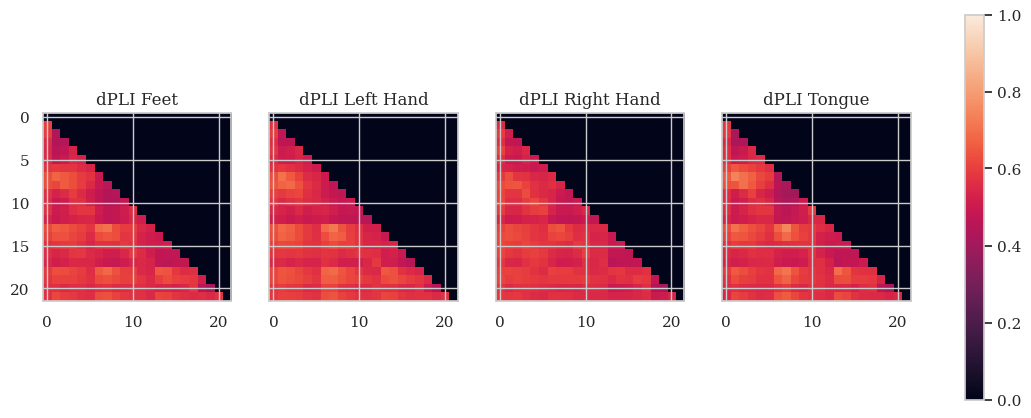

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(14, 5), sharey=True)
axs[0].imshow(conn_feet.get_data("dense"), vmin=0, vmax=1)
axs[0].set_title("dPLI Feet")

axs[1].imshow(conn_left_hand.get_data("dense"), vmin=0, vmax=1)
axs[1].set_title("dPLI Left Hand")

im = axs[2].imshow(conn_right_hand.get_data("dense"), vmin=0, vmax=1)
axs[2].set_title("dPLI Right Hand")

im = axs[3].imshow(conn_tongue.get_data("dense"), vmin=0, vmax=1)
axs[3].set_title("dPLI Tongue")

fig.colorbar(im, ax=axs.ravel())
plt.show()

In [21]:
conn_feet_np = np.squeeze(conn_feet.get_data("dense"))
conn_left_hand_np = np.squeeze(conn_left_hand.get_data("dense"))
conn_right_hand_np = np.squeeze(conn_right_hand.get_data("dense"))
conn_tongue_np = np.squeeze(conn_tongue.get_data("dense"))

EEG_Locations_list = []
print(conn_feet_np.shape, conn_left_hand_np.shape, conn_right_hand_np.shape, conn_tongue_np.shape)
for k, v in EEG_Locations.items():
	EEG_Locations_list.append(v)

EEG_Locations_list = np.array(EEG_Locations_list, dtype=float)
print(EEG_Locations_list.shape)


conn_feet_np_symm = symmetrize(conn_feet_np)
conn_left_hand_np_symm = symmetrize(conn_left_hand_np)
conn_right_hand_np_symm = symmetrize(conn_right_hand_np)
conn_tongue_np_symm = symmetrize(conn_tongue_np)

NameError: name 'conn_feet' is not defined

In [ ]:
def make_directed_dpli(m):
	directed = np.zeros(m.shape)
	for sensor_1 in range(m.shape[0]):
		for sensor_2 in range(sensor_1):
			if m[sensor_1, sensor_2] <= 0.5:
				directed[sensor_1, sensor_2] = 2 * abs(m[sensor_1, sensor_2] - 0.5)
			else:
				directed[sensor_2, sensor_1] = -2 * abs(m[sensor_1, sensor_2] - 0.5)
	return directed

/tmp/ipykernel_140691/1602887087.py:1: UserWarning: 'adjacency_matrix' is not symmetric. A directed graph will be plotted.
  plotting.plot_connectome(make_directed_dpli(conn_feet_np), EEG_Locations_list, title="dPLI - Feet", edge_cmap = colormaps['seismic'], edge_threshold="95%", colorbar=True)
/tmp/ipykernel_140691/1602887087.py:2: UserWarning: 'adjacency_matrix' is not symmetric. A directed graph will be plotted.
  plotting.plot_connectome(make_directed_dpli(conn_left_hand_np), EEG_Locations_list, title="dPLI - Left Hand", edge_cmap = colormaps['seismic'], edge_threshold="95%", colorbar=True)
/tmp/ipykernel_140691/1602887087.py:3: UserWarning: 'adjacency_matrix' is not symmetric. A directed graph will be plotted.
  plotting.plot_connectome(make_directed_dpli(conn_right_hand_np), EEG_Locations_list, title="dPLI - Right Hand", edge_cmap = colormaps['seismic'], edge_threshold="95%", colorbar=True)
/tmp/ipykernel_140691/1602887087.py:4: UserWarning: 'adjacency_matrix' is not symmetric. A

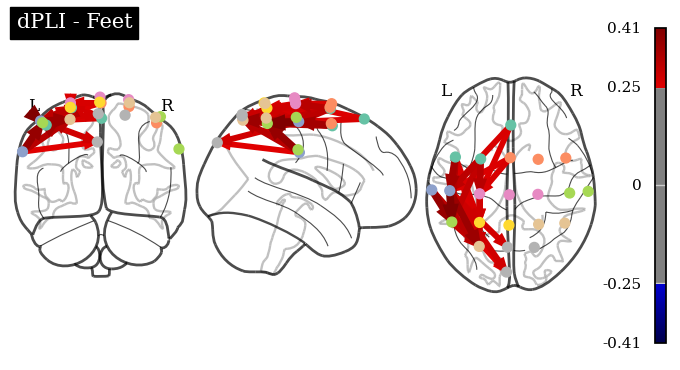

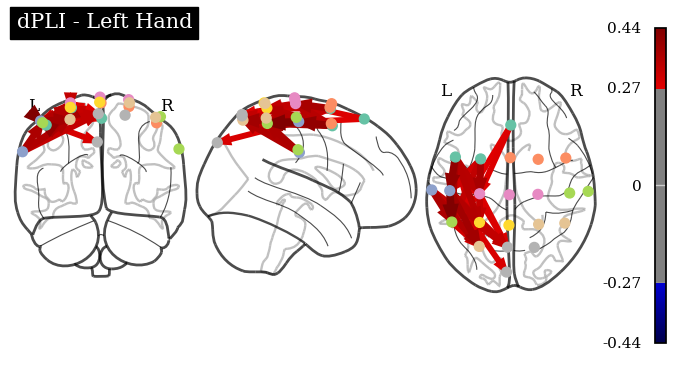

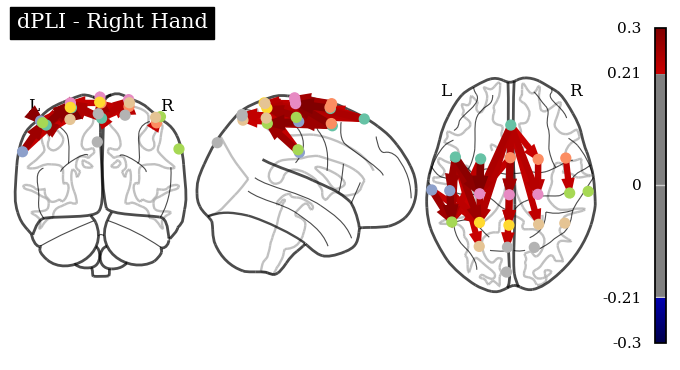

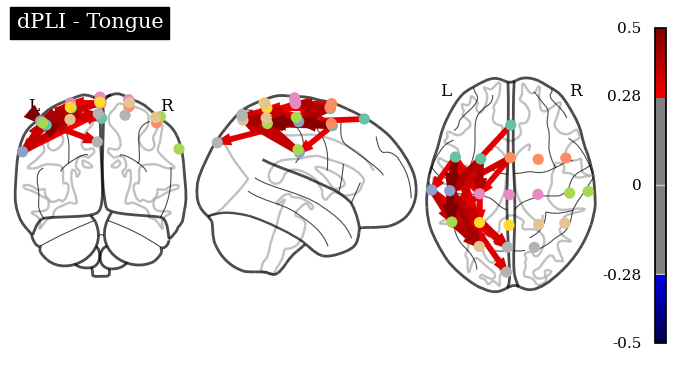

In [ ]:
plotting.plot_connectome(make_directed_dpli(conn_feet_np), EEG_Locations_list, title="dPLI - Feet", edge_cmap = colormaps['seismic'], edge_threshold="95%", colorbar=True)
plotting.plot_connectome(make_directed_dpli(conn_left_hand_np), EEG_Locations_list, title="dPLI - Left Hand", edge_cmap = colormaps['seismic'], edge_threshold="95%", colorbar=True)
plotting.plot_connectome(make_directed_dpli(conn_right_hand_np), EEG_Locations_list, title="dPLI - Right Hand", edge_cmap = colormaps['seismic'], edge_threshold="95%", colorbar=True)
plotting.plot_connectome(make_directed_dpli(conn_tongue_np), EEG_Locations_list, title="dPLI - Tongue", edge_cmap = colormaps['seismic'], edge_threshold="95%", colorbar=True)

### wPLI Filtering

In [ ]:
conn_feet_wpli = spectral_connectivity_epochs(
	X_feet,
	method="wpli",
	sfreq=250,
	fmin=8, # So we get at least 5 cycles
	fmax=30,
	faverage=True,
	verbose=False,
	n_jobs = 4
)

conn_left_hand_wpli = spectral_connectivity_epochs(
	X_left_hand,
	method="wpli",
	sfreq=250,
	fmin=8, # So we get at least 5 cycles
	fmax=30,
	faverage=True,
	verbose=False,
	n_jobs = 4
)

conn_right_hand_wpli = spectral_connectivity_epochs(
	X_right_hand,
	method="wpli",
	sfreq=250,
	fmin=8, # So we get at least 5 cycles
	fmax=30,
	faverage=True,
	verbose=False,
	n_jobs=4
)

conn_tongue_wpli = spectral_connectivity_epochs(
	X_tongue,
	method="wpli",
	sfreq=250,
	fmin=8, # So we get at least 5 cycles
	fmax=30,
	faverage=True,
	verbose=False,
	n_jobs=4
)

print(conn_feet_wpli.shape, conn_left_hand_wpli.shape, conn_right_hand_wpli.shape, conn_tongue_wpli.shape)

(484, 1) (484, 1) (484, 1) (484, 1)


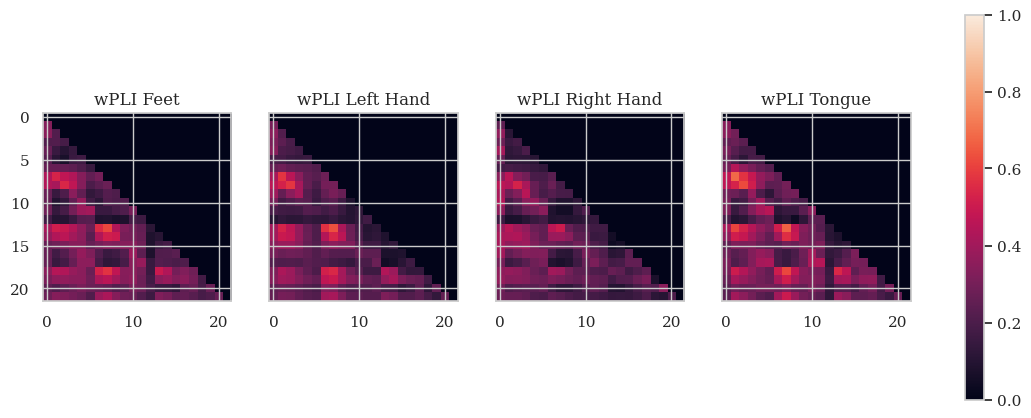

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(14, 5), sharey=True)
axs[0].imshow(conn_feet_wpli.get_data("dense"), vmin=0, vmax=1)
axs[0].set_title("wPLI Feet")

axs[1].imshow(conn_left_hand_wpli.get_data("dense"), vmin=0, vmax=1)
axs[1].set_title("wPLI Left Hand")

im = axs[2].imshow(conn_right_hand_wpli.get_data("dense"), vmin=0, vmax=1)
axs[2].set_title("wPLI Right Hand")

im = axs[3].imshow(conn_tongue_wpli.get_data("dense"), vmin=0, vmax=1)
axs[3].set_title("wPLI Tongue")

fig.colorbar(im, ax=axs.ravel())
plt.show()

In [96]:
conn_feet_wpli_np = np.squeeze(conn_feet_wpli.get_data("dense"))
conn_left_hand_wpli_np = np.squeeze(conn_left_hand_wpli.get_data("dense"))
conn_right_hand_wpli_np = np.squeeze(conn_right_hand_wpli.get_data("dense"))
conn_tongue_wpli_np = np.squeeze(conn_tongue_wpli.get_data("dense"))

conn_feet_wpli_np_symm = symmetrize(conn_feet_wpli_np)
conn_left_hand_wpli_np_symm = symmetrize(conn_left_hand_wpli_np)
conn_right_hand_wpli_np_symm = symmetrize(conn_right_hand_wpli_np)
conn_tongue_wpli_np_symm = symmetrize(conn_tongue_wpli_np)


In [97]:
print((conn_feet_wpli_np > 0.4).sum())
print((conn_left_hand_wpli_np > 0.4).sum())
print((conn_right_hand_wpli_np > 0.4).sum())
print((conn_tongue_wpli_np > 0.4).sum())

32
29
17
44


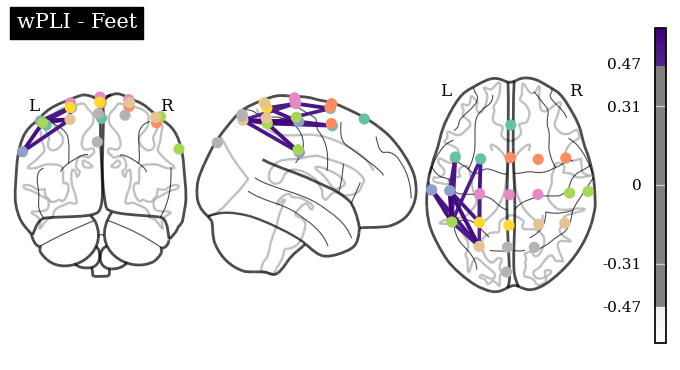

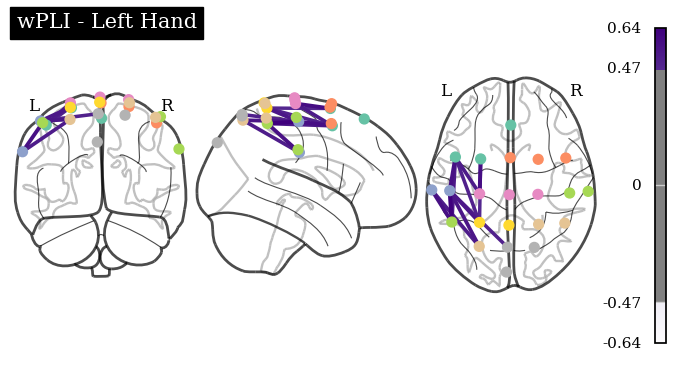

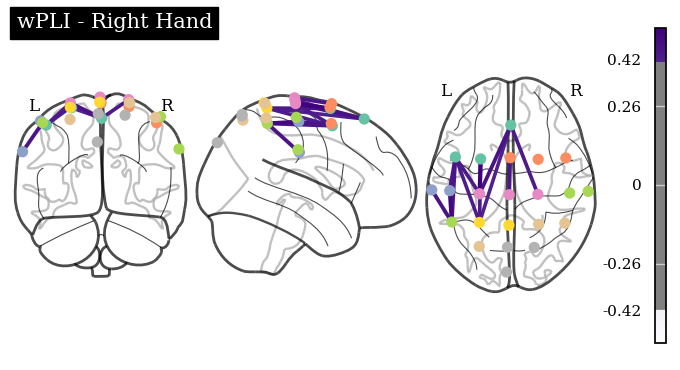

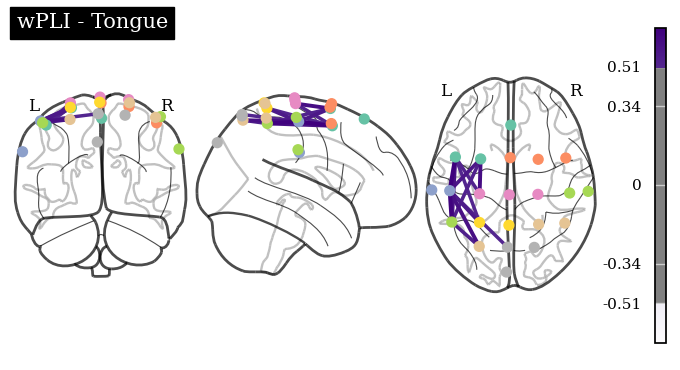

In [98]:
plotting.plot_connectome(conn_feet_wpli_np_symm, EEG_Locations_list, title="wPLI - Feet", edge_cmap = colormaps['Purples'], edge_threshold="95%", colorbar=True)
plotting.plot_connectome(conn_left_hand_wpli_np_symm, EEG_Locations_list, title="wPLI - Left Hand", edge_cmap = colormaps['Purples'], edge_threshold="95%", colorbar=True)
plotting.plot_connectome(conn_right_hand_wpli_np_symm, EEG_Locations_list, title="wPLI - Right Hand", edge_cmap = colormaps['Purples'], edge_threshold="95%", colorbar=True)
plotting.plot_connectome(conn_tongue_wpli_np_symm, EEG_Locations_list, title="wPLI - Tongue", edge_cmap = colormaps['Purples'], edge_threshold="95%", colorbar=True)

In [99]:
subjects = [1]
with warnings.catch_warnings(action="ignore"):
	epochs, y, metadata = paradigm.get_data(dataset=datasetMotorImagery, subjects=subjects, return_epochs=True)


Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
576 matching events found
No baseline correction applied


In [100]:
# Now, visualize the connectivity in 3D:

#connectivity_fig = plot_sensors_connectivity(epochs.info, conn_feet_wpli.get_data(output="dense")[:, :, 0], cbar_label='Connectivity - Feet')
#screenshot = connectivity_fig.plotter.screenshot('feet_hand.png')

In [101]:
#connectivity_fig = plot_sensors_connectivity(epochs.info, conn_left_hand_wpli.get_data(output="dense")[:, :, 0], cbar_label='Connectivity - Left Hand')
#screenshot = connectivity_fig.plotter.screenshot('left_hand.png')


In [102]:
#connectivity_fig = plot_sensors_connectivity(epochs.info, conn_right_hand_wpli.get_data(output="dense")[:, :, 0], cbar_label='Connectivity - Right Hand')
#screenshot = connectivity_fig.plotter.screenshot('right_hand.png')

In [103]:
#connectivity_fig = plot_sensors_connectivity(epochs.info, conn_tongue_wpli.get_data(output="dense")[:, :, 0], cbar_label='Connectivity - Tongue')
#screenshot = connectivity_fig.plotter.screenshot('tongue.png')

In [104]:
feet_conn_indices = np.nonzero(conn_feet_wpli_np > 0.4)
left_hand_conn_indices = np.nonzero(conn_left_hand_wpli_np > 0.4)
right_hand_conn_indices = np.nonzero(conn_right_hand_wpli_np > 0.4)
tongue_conn_indices = np.nonzero(conn_tongue_wpli_np > 0.4)
print(type(feet_conn_indices))

<class 'tuple'>


In [105]:
psi_feet = phase_slope_index(
	X_feet,
	mode="multitaper",
	sfreq=250,
	fmin=8,
	fmax=30,
	verbose=False
)

psi_left_hand = phase_slope_index(
	X_left_hand,
	mode="multitaper",
	sfreq=250,
	fmin=8,
	fmax=30,
	verbose=False
)

psi_right_hand = phase_slope_index(
	X_right_hand,
	mode="multitaper",
	sfreq=250,
	fmin=8,
	fmax=30,
	verbose=False
)

psi_tongue = phase_slope_index(
	X_tongue,
	mode="multitaper",
	sfreq=250,
	fmin=8,
	fmax=30,
	verbose=False
)


In [106]:
print(np.max(psi_feet.get_data("dense")))
print(np.min(psi_feet.get_data("dense")))

print(np.max(psi_left_hand.get_data("dense")))
print(np.min(psi_left_hand.get_data("dense")))

print(np.max(psi_right_hand.get_data("dense")))
print(np.min(psi_right_hand.get_data("dense")))

print(np.max(psi_tongue.get_data("dense")))
print(np.min(psi_tongue.get_data("dense")))

0.06476506004514715
-0.09189090059058963
0.054038882860376156
-0.07574058606200593
0.06992734530136017
-0.04329336361932543
0.07460612748468051
-0.11227268414070622


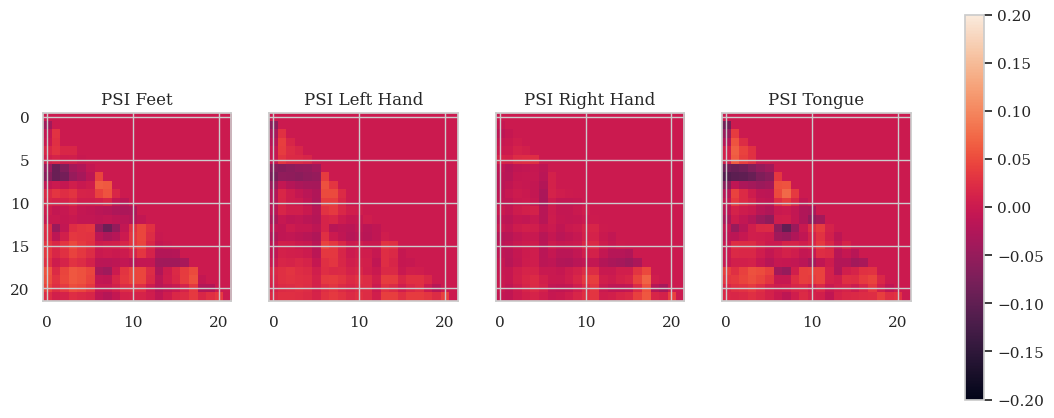

In [107]:
fig, axs = plt.subplots(1, 4, figsize=(14, 5), sharey=True)
axs[0].imshow(psi_feet.get_data("dense"), vmin=-.2, vmax=.2)
axs[0].set_title("PSI Feet")

axs[1].imshow(psi_left_hand.get_data("dense"), vmin=-.2, vmax=.2)
axs[1].set_title("PSI Left Hand")

im = axs[2].imshow(psi_right_hand.get_data("dense"), vmin=-.2, vmax=.2)
axs[2].set_title("PSI Right Hand")

im = axs[3].imshow(psi_tongue.get_data("dense"), vmin=-.2, vmax=.2)
axs[3].set_title("PSI Tongue")
fig.colorbar(im, ax=axs.ravel())
plt.show()

In [108]:
def make_directed_psi(m):
	directed = np.zeros(m.shape)
	for sensor_1 in range(m.shape[0]):
		for sensor_2 in range(sensor_1):
			if m[sensor_1, sensor_2] <= 0:
				directed[sensor_1, sensor_2] = m[sensor_1, sensor_2]
			else:
				directed[sensor_2, sensor_1] = m[sensor_1, sensor_2]
	return directed

/tmp/ipykernel_140691/2441374374.py:1: UserWarning: 'adjacency_matrix' is not symmetric. A directed graph will be plotted.
  plotting.plot_connectome(make_directed_psi(psi_feet.get_data("dense")[:, :, 0]) , EEG_Locations_list, title="psi - Feet", edge_cmap = colormaps['seismic'], edge_threshold="95%", colorbar=True)


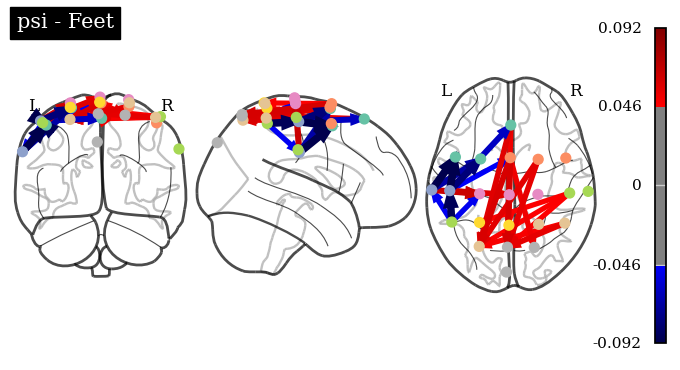

In [109]:
plotting.plot_connectome(make_directed_psi(psi_feet.get_data("dense")[:, :, 0]) , EEG_Locations_list, title="psi - Feet", edge_cmap = colormaps['seismic'], edge_threshold="95%", colorbar=True)

/tmp/ipykernel_140691/1425615879.py:1: UserWarning: 'adjacency_matrix' is not symmetric. A directed graph will be plotted.
  plotting.plot_connectome(make_directed_psi(psi_left_hand.get_data("dense")[:, :, 0]) , EEG_Locations_list, title="psi - Left Hand", edge_cmap = colormaps['seismic'], edge_threshold="95%", colorbar=True)


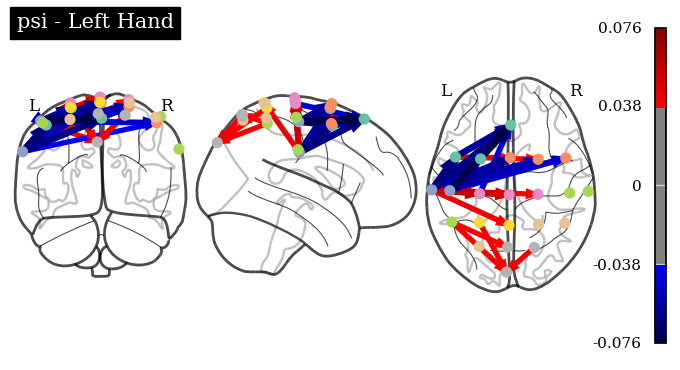

In [110]:
plotting.plot_connectome(make_directed_psi(psi_left_hand.get_data("dense")[:, :, 0]) , EEG_Locations_list, title="psi - Left Hand", edge_cmap = colormaps['seismic'], edge_threshold="95%", colorbar=True)

/tmp/ipykernel_140691/644546406.py:1: UserWarning: 'adjacency_matrix' is not symmetric. A directed graph will be plotted.
  plotting.plot_connectome(make_directed_psi(psi_right_hand.get_data("dense")[:, :, 0]) , EEG_Locations_list, title="psi - Right Hand", edge_cmap = colormaps['seismic'], edge_threshold="95%", colorbar=True)


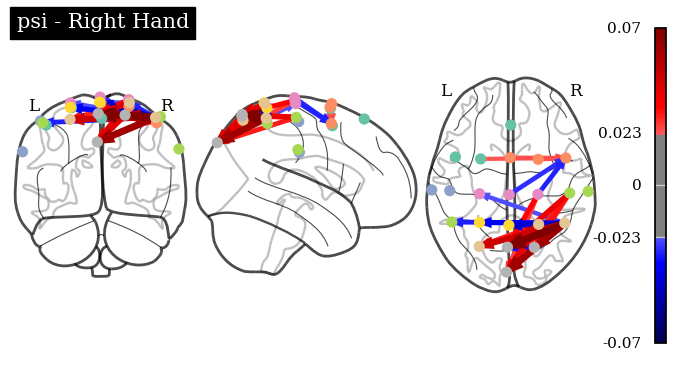

In [111]:
plotting.plot_connectome(make_directed_psi(psi_right_hand.get_data("dense")[:, :, 0]) , EEG_Locations_list, title="psi - Right Hand", edge_cmap = colormaps['seismic'], edge_threshold="95%", colorbar=True)

/tmp/ipykernel_140691/3888370395.py:1: UserWarning: 'adjacency_matrix' is not symmetric. A directed graph will be plotted.
  plotting.plot_connectome(make_directed_psi(psi_tongue.get_data("dense")[:, :, 0]) , EEG_Locations_list, title="psi - Tongue", edge_cmap = colormaps['seismic'], edge_threshold="95%", colorbar=True)


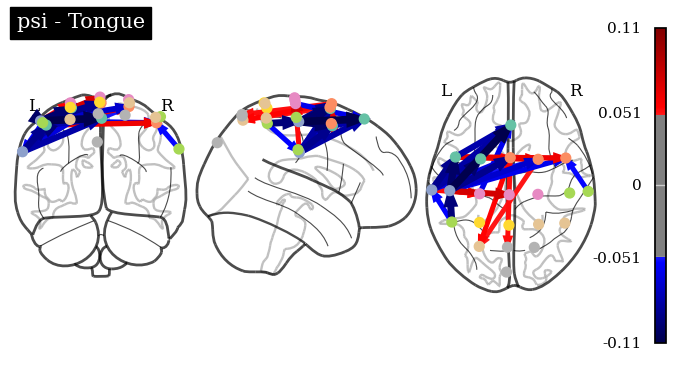

In [112]:
plotting.plot_connectome(make_directed_psi(psi_tongue.get_data("dense")[:, :, 0]) , EEG_Locations_list, title="psi - Tongue", edge_cmap = colormaps['seismic'], edge_threshold="95%", colorbar=True)

### Neurolib Attempt

In [6]:
wpli_all = spectral_connectivity_epochs(
	X[:, :, :250],
	method="wpli",
	sfreq=250,
	fmin=8, # So we get at least 5 cycles
	fmax=30,
	faverage=True,
	verbose=False,
	n_jobs=4
)

print(wpli_all.get_data("dense").shape)

(22, 22, 1)


In [7]:
wpli_all = wpli_all.get_data("dense")[:, :, 0]
wpli_all = symmetrize(wpli_all)

In [8]:
# Let's import the neurolib
from neurolib.models.wc import WCModel
from scipy.spatial import distance_matrix
import xarray as xr
import neurolib.utils.functions as func
import seaborn as sns
from neurolib.utils.signal import Signal 


In [9]:
fiber_length_matrix = distance_matrix(EEG_Locations_list, EEG_Locations_list)
print(fiber_length_matrix.shape)
print(np.min(fiber_length_matrix))
print(np.max(fiber_length_matrix))

(22, 22)
0.0
132.65580236084662


In [10]:
wc = WCModel(Cmat=wpli_all, Dmat=fiber_length_matrix, seed=0)

In [11]:
wc.params['duration'] = 2*60*1000
wc.params['dt'] = 0.004

In [12]:
wc.run()

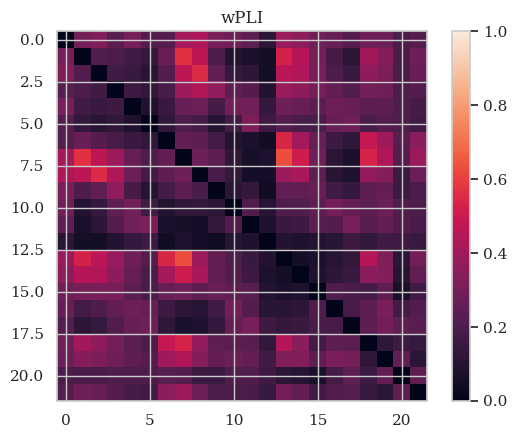

In [13]:
plt.imshow(wpli_all, vmin=0, vmax=1)
plt.title("wPLI")
plt.colorbar()

In [14]:
# Create xr DataArray from the simulated excitatory timeseries (keeping the region labels)
sim_signal = xr.DataArray(wc.exc[:, int(1000/wc.params.dt):], dims=("regions", "time"), coords={"regions": range(len(EEG_Locations.keys())), "time": wc.t[int(1000/wc.params.dt):]/1000})

sim_signal = Signal(sim_signal)
sim_signal.resample(to_frequency=100)
# Filter signal
sim_signal.filter(8, 30, inplace=True)
# Extract signal envelope 
sim_signal.hilbert_transform('amplitude', inplace=True)

Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


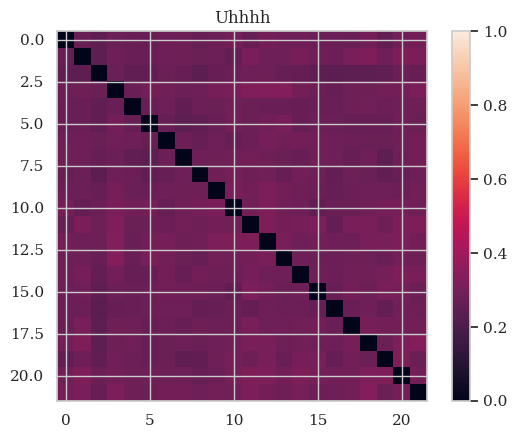

In [15]:
sim_fc = func.fc(sim_signal.data)

# Set diagonal to zero
np.fill_diagonal(sim_fc, 0)

plt.imshow(sim_fc, vmin=0, vmax=1)
plt.title("Uhhhh")
plt.colorbar()

In [16]:
wpli_all = symmetrize(wpli_all)

In [17]:
struct_emp = np.corrcoef(wpli_all.flatten(), fiber_length_matrix.flatten())[0,1]
sim_emp = np.corrcoef(wpli_all.flatten(), sim_fc.flatten())[0,1]

print(struct_emp)
print(sim_emp)

-0.04785248362574905
0.3482640831274881
